In [79]:
%reload_ext autoreload
%autoreload 2

import os
import io
import pickle
import sys
import datetime

import boto3
import sagemaker
from sagemaker.tensorflow.estimator import TensorFlow
from sagemaker.tensorflow import TensorFlowModel
from sagemaker.tuner import ContinuousParameter, IntegerParameter, CategoricalParameter, HyperparameterTuner

import numpy as np
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Nopep8
import tensorflow as tf

import matplotlib.pyplot as plt

## S3

In [2]:
s3 = boto3.client('s3')

s3_bucket = 'yang-ml-sagemaker'
s3_key = 'lesion-segmentation'

train_val_path = {'train': f's3://{s3_bucket}/{s3_key}/input-data/train',
                  'val': f's3://{s3_bucket}/{s3_key}/input-data/val'}
train_val_path

{'train': 's3://yang-ml-sagemaker/lesion-segmentation/input-data/train',
 'val': 's3://yang-ml-sagemaker/lesion-segmentation/input-data/val'}

## Sagemaker

In [40]:
sagemaker_session = sagemaker.Session(default_bucket=s3_bucket)
sagemaker_session
sm_boto3 = boto3.client('sagemaker')
role = sagemaker.get_execution_role()
s3_uploader = sagemaker.s3.S3Uploader()
instance_type = 'ml.c5.9xlarge'
instance_count = 1

src_dir_path = os.path.join(os.path.dirname(os.getcwd()), 'src')
fine_tune_script_path = 'fine_tune_entry.py'
model_dir = '/opt/ml/model'

PY_VERSION = 'py39'
FRAMEWORK_VERSION = '2.9' # Need at least 2.9 for segmentation-model to work

# Get today's date in YYYYMMDD format
today = datetime.datetime.today().strftime('%Y-%m-%d')

# Define endpoint name with version and date
endpoint_name = f'fine-tune-lesion-{today}'

## Tensorflow Estimator

In [41]:
tf_estimator = TensorFlow(
    entry_point=fine_tune_script_path,
    source_dir=src_dir_path,
    role=role,
    py_version=PY_VERSION,
    framework_version=FRAMEWORK_VERSION,
    model_dir=model_dir,
    instance_type=instance_type,
    instance_count=instance_count
)
tf_estimator

## Hyperparameter Tuning

In [42]:
search_space = {
    # Data augmentation
    'random_contrast_factor': ContinuousParameter(min_value=0.1, max_value=1.0),
    'random_flip_mode': CategoricalParameter(values=['horizontal', 'vertical', 'horizontal_and_vertical']),
    'random_rotation_factor': ContinuousParameter(min_value=0.1, max_value=0.5),
    'random_zoom_factor': ContinuousParameter(min_value=0.1, max_value=0.5),
    # Optimization 
    'learning_rate': ContinuousParameter(min_value=1e-5, max_value=1e-2, scaling_type='Logarithmic'),
    'clipnorm': ContinuousParameter(min_value=0.2, max_value=1.0),
    'batch_size': CategoricalParameter(values=[64, 128, 256]),
    'epochs': IntegerParameter(min_value=10, max_value=15)
}

objective_metric_name = 'dice_loss'
objective_type = 'Minimize'
metric_definitions = [
    {
        'Name': objective_metric_name,
        "Regex": 'Best validation dice loss after fine-tuning: ([0-9\\.]+)',
    }
]
base_tuning_job_name = f'segmentation-fine-tune-job-{today}'

In [43]:
hpo_tuner = HyperparameterTuner(
    estimator=tf_estimator,
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=search_space,
    metric_definitions=metric_definitions,
    strategy='Bayesian',
    objective_type=objective_type,
    max_jobs=50,
    max_parallel_jobs=5,
    base_tuning_job_name=base_tuning_job_name
)

In [ ]:
hpo_tuner.fit(train_val_path)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Check HPO results:

In [46]:
hpo_analytics = sagemaker.HyperparameterTuningJobAnalytics(hpo_tuner.latest_tuning_job.name)

hpo_results = hpo_analytics.dataframe()

hpo_results.sort_values("FinalObjectiveValue", ascending=True).head(10)

,batch_size,clipnorm,epochs,learning_rate,random_contrast_factor,random_flip_mode,random_rotation_factor,random_zoom_factor,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
4,"""64""",0.562390,14.0,0.001341,0.969324,"""horizontal""",0.100000,0.182382,segmentation-fine-tu-230521-0042-046-fcac63cd,Completed,0.410009,2023-05-21 06:20:20+00:00,2023-05-21 07:16:16+00:00,3356.0
19,"""64""",0.338770,14.0,0.000853,0.975626,"""horizontal""",0.158544,0.159909,segmentation-fine-tu-230521-0042-031-8ce7290e,Completed,0.453281,2023-05-21 04:17:36+00:00,2023-05-21 05:12:41+00:00,3305.0
17,"""64""",0.452353,14.0,0.001842,0.979583,"""horizontal""",0.141847,0.192912,segmentation-fine-tu-230521-0042-033-36cb0583,Completed,0.458035,2023-05-21 04:32:06+00:00,2023-05-21 05:23:30+00:00,3084.0
10,"""64""",0.402089,14.0,0.001524,0.992632,"""horizontal""",0.202283,0.177030,segmentation-fine-tu-230521-0042-040-d3bd96d1,Completed,0.465584,2023-05-21 05:25:30+00:00,2023-05-21 06:07:17+00:00,2507.0
9,"""64""",0.438492,13.0,0.000919,0.992214,"""horizontal""",0.203898,0.211961,segmentation-fine-tu-230521-0042-041-07d50b5d,Completed,0.496723,2023-05-21 05:33:08+00:00,2023-05-21 06:24:02+00:00,3054.0
12,"""64""",0.295019,14.0,0.001126,1.000000,"""vertical""",0.100000,0.409594,segmentation-fine-tu-230521-0042-038-0984ce08,Completed,0.515862,2023-05-21 05:13:28+00:00,2023-05-21 06:03:35+00:00,3007.0
25,"""64""",0.413037,15.0,0.000934,0.970139,"""horizontal_and_vertical""",0.163248,0.195937,segmentation-fine-tu-230521-0042-025-3ce95c3f,Completed,0.540837,2023-05-21 03:15:05+00:00,2023-05-21 04:06:38+00:00,3093.0
23,"""64""",0.414291,13.0,0.000928,1.000000,"""horizontal""",0.261880,0.327329,segmentation-fine-tu-230521-0042-027-f6477ebd,Completed,0.557981,2023-05-21 03:45:19+00:00,2023-05-21 04:24:59+00:00,2380.0
34,"""64""",0.396248,15.0,0.000921,0.959098,"""horizontal_and_vertical""",0.244957,0.246209,segmentation-fine-tu-230521-0042-016-7e99693b,Completed,0.590485,2023-05-21 02:13:35+00:00,2023-05-21 02:59:42+00:00,2767.0
24,"""64""",0.756178,14.0,0.000862,1.000000,"""horizontal""",0.234427,0.229756,segmentation-fine-tu-230521-0042-026-f31e9e76,Completed,0.596756,2023-05-21 03:32:53+00:00,2023-05-21 04:16:59+00:00,2646.0


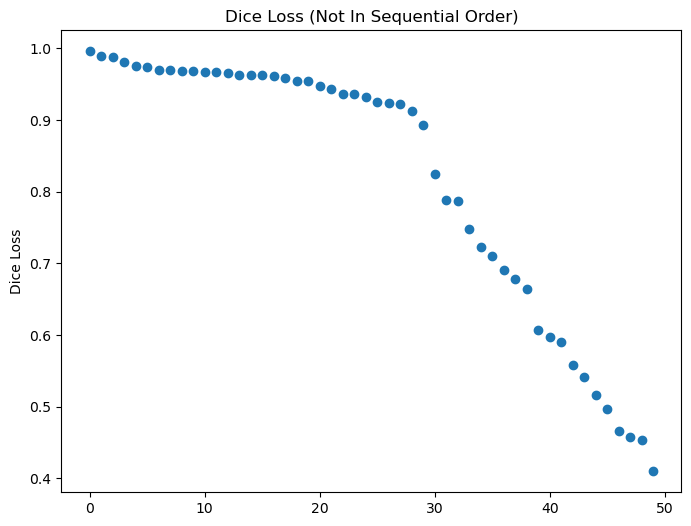

In [51]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(range(hpo_results.shape[0]), hpo_results.sort_values("FinalObjectiveValue", ascending=False)['FinalObjectiveValue'])
plt.title('Dice Loss (Not In Sequential Order)')
plt.ylabel('Dice Loss')
plt.show();

## Deploy Best Model

In [52]:
# Obtain the name of best training job
best_model_name = sm_boto3.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=hpo_tuner.latest_tuning_job.name
)['BestTrainingJob']['TrainingJobName']

# Obtain s3 path to model artifacts
best_model_s3_path = sm_boto3.describe_training_job(
    TrainingJobName=best_model_name
)["ModelArtifacts"]["S3ModelArtifacts"]

print(f'Best model artifacts persisted at {best_model_s3_path}')

Best model artifacts persisted at s3://sagemaker-us-east-1-722696965592/segmentation-fine-tu-230521-0042-046-fcac63cd/output/model.tar.gz


In [54]:
best_model = TensorFlowModel(
    model_data=best_model_s3_path,
    role=role,
    framework_version=FRAMEWORK_VERSION
)

predictor = best_model.deploy(
    initial_instance_count=1,
    instance_type='ml.c5.4xlarge',
    endpoint_name=endpoint_name + '-v1'
)

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


---!

## Inference on Test Set

In [ ]:
test_images = np.load(io.BytesIO(s3.get_object(Bucket=s3_bucket, Key=f'{s3_key}/input-data/test/test_images.npy')['Body'].read()))
test_masks = np.load(io.BytesIO(s3.get_object(Bucket=s3_bucket, Key=f'{s3_key}/input-data/test/test_masks.npy')['Body'].read()))

test_images.shape, test_masks.shape

In [107]:
# Take a sample of 10 test images
random_indices = np.random.randint(low=0, high=test_images.shape[0], size=10)

predictions = predictor.predict(test_images[random_indices])
# A list of lists 
predictions = predictions['predictions']
# Convert each list to numpy array and add new axis (first dimension)
predictions = [np.array(pred)[np.newaxis, :, :, :] for pred in predictions]
predictions = np.vstack(predictions)

predictions.shape

(10, 256, 256, 1)

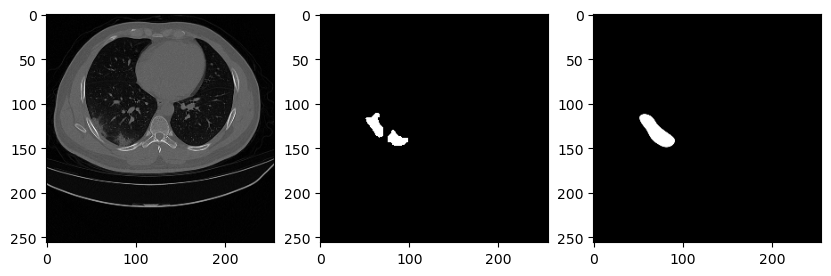

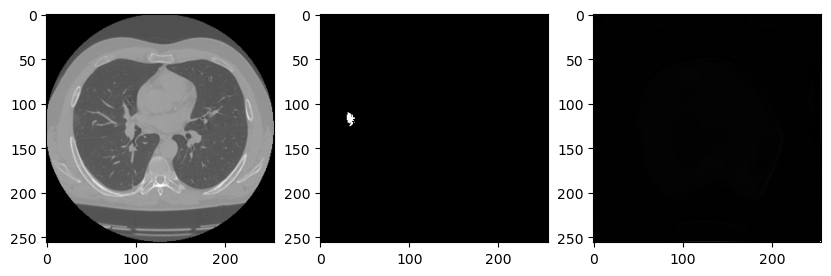

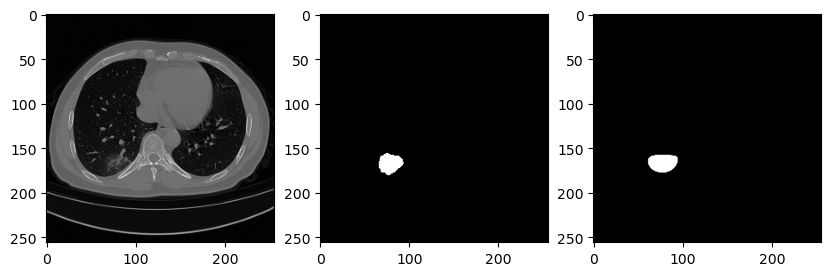

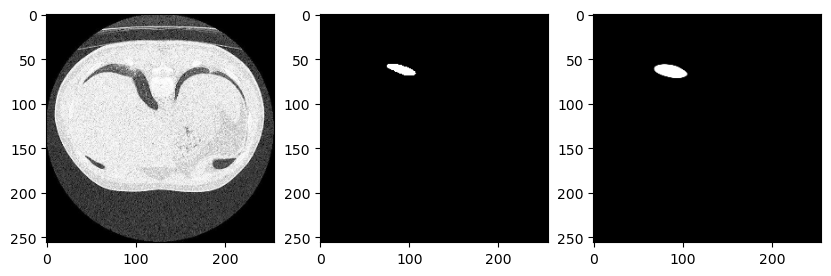

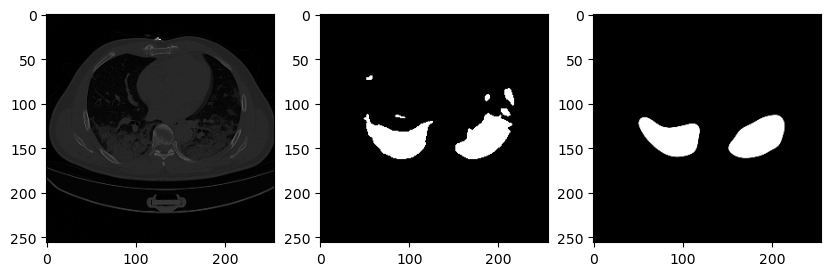

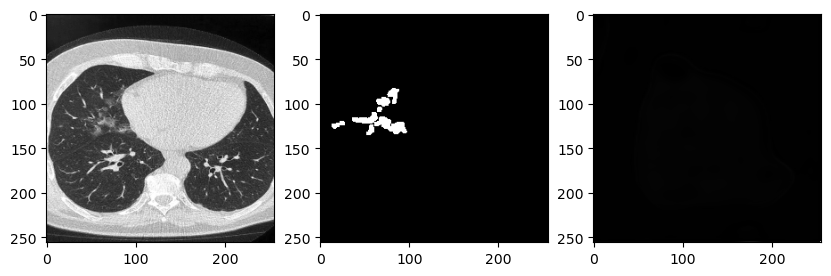

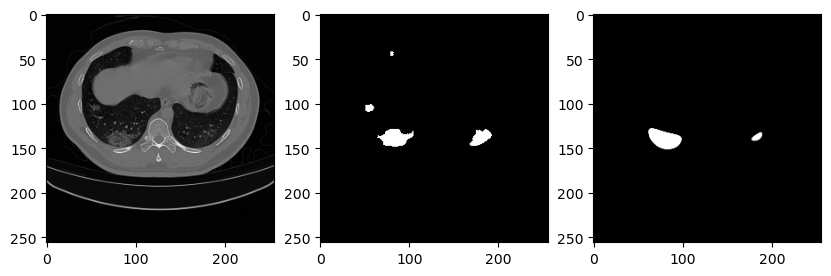

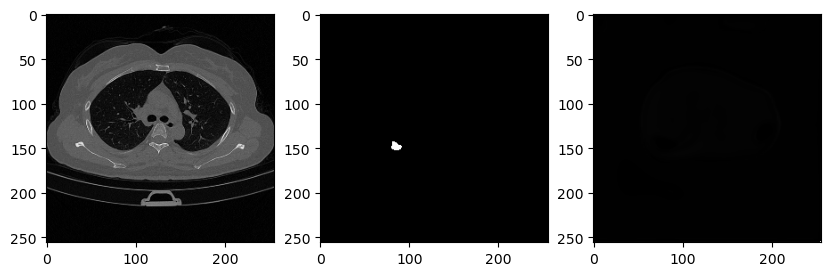

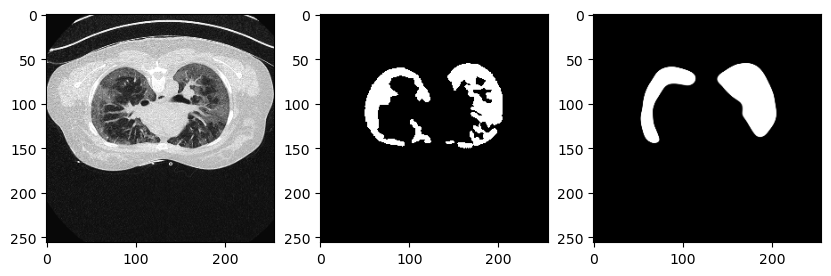

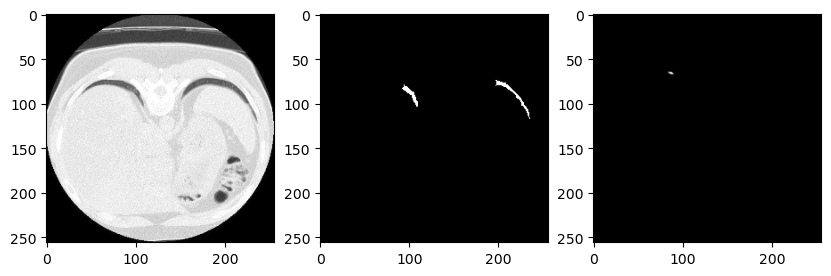

In [108]:
for i, indx in enumerate(random_indices):
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 8))
    
    img = axes[0]
    img.imshow(test_images[indx], cmap='gray')
    
    true_mask = axes[1]
    true_mask.imshow(test_masks[indx], cmap='gray')
    
    pred_mask = axes[2]
    pred_mask.imshow(predictions[i], cmap='gray')

## Clean-up

In [114]:
sm_boto3.delete_endpoint(EndpointName=predictor.endpoint_name)
sm_boto3.delete_endpoint_config(EndpointConfigName=predictor.endpoint_name)

{'ResponseMetadata': {'RequestId': 'b7211e34-f1bf-48b0-be64-2fac7a31aef1',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'b7211e34-f1bf-48b0-be64-2fac7a31aef1',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Sun, 21 May 2023 09:41:53 GMT'},
  'RetryAttempts': 0}}

In [115]:
sm_boto3.close()